In [13]:
import pandas as pd
import json
import csv
import sys
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import numpy as np
from nltk.corpus import stopwords
import string
import emoji
import regex
import string
from datetime import timedelta
import matplotlib.dates as mdates
import seaborn as sn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from unidecode import unidecode as unidec
from sklearn.model_selection import RandomizedSearchCV

In [14]:
dir_="C:\\Users\\Alex\\Personal-Code\\ACE_592_Dating_Sim\\Wrangled_Data\\"

In [15]:
#reads the csv files into memory for each dating app.
#Data has already been cleaed and all three files share the same columns
df_T = pd.read_csv(dir_ + "sent_Tinder.csv")
df_T = df_T[['userName', 'full_text','clean_text', 'score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]

df_B = pd.read_csv(dir_ + "sent_Bumble.csv")
df_B = df_B[['userName', 'full_text','clean_text', 'score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]

df_H = pd.read_csv(dir_ + "sent_Hinge.csv")
df_H = df_H[['userName', 'full_text','clean_text', 'score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]

In [16]:
df_T.head(5);

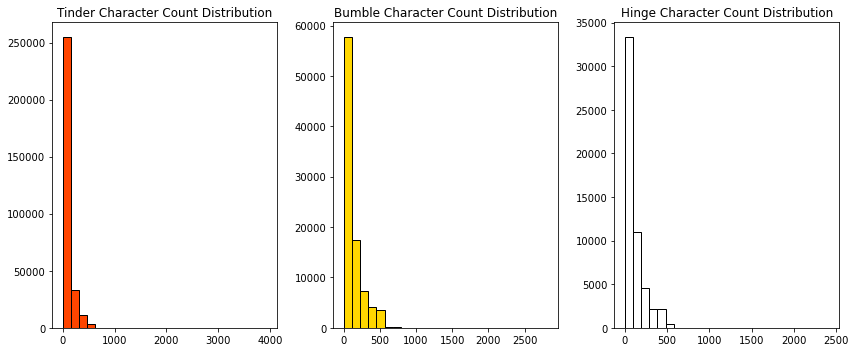

In [10]:
#plots the overall scores of the three apps over their lifespans
fig, axs = plt.subplots(1, 3, tight_layout=True, sharey=False, 
                        figsize = (12,5))
                       #title = 'Star Ratings for Tinder, Bumble, and Hinge')

# ax.set_xlim(1,5)
# ax.set_xticks([1,2,3,4,5])

axs[0].hist(df_T['word_count'], bins = 25, color = "orangered", edgecolor = 'black')
axs[0].title.set_text('Tinder Character Count Distribution')
# axs[0].set_xlim(0.85,5.15)
# axs[0].set_xticks([1,2,3,4,5])

axs[1].hist(df_B['word_count'], bins = 25, color = 'gold', edgecolor = 'black')
axs[1].title.set_text('Bumble Character Count Distribution')
# axs[1].set_xlim(0.85,5.15)
# axs[1].set_xticks([1,2,3,4,5])

axs[2].hist(df_H['word_count'], bins = 25, color = 'white', edgecolor = 'black')
axs[2].title.set_text('Hinge Character Count Distribution')
# axs[2].set_xlim(0.85,5.15)
# axs[2].set_xticks([1,2,3,4,5])

### Let's analyze these features before we start trying to train a model. Starting with Corr Coeff's

#### Tinder Correlation Coeff's

In [4]:
dfCorrT = df_T[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
dfCorrT.corr()

,score,comp_sent,neg_sent,pos_sent,neu_sent,word_count
score,1.000000,0.592193,-0.436203,0.620677,-0.411953,-0.398248
comp_sent,0.592193,1.000000,-0.630197,0.657125,-0.319295,-0.213058
neg_sent,-0.436203,-0.630197,1.000000,-0.387802,-0.173846,0.025361
pos_sent,0.620677,0.657125,-0.387802,1.000000,-0.816623,-0.331127
neu_sent,-0.411953,-0.319295,-0.173846,-0.816623,1.000000,0.348570
word_count,-0.398248,-0.213058,0.025361,-0.331127,0.348570,1.000000


Tinder: Seems like comp_sent, neg_sent, and pos_sent all do pretty well. WC and Neu aren't bad either. 

#### Bumble Correlation Coeff's

In [5]:
dfCorrB = df_B[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
dfCorrB.corr()

,score,comp_sent,neg_sent,pos_sent,neu_sent,word_count
score,1.000000,0.553421,-0.401492,0.607021,-0.409056,-0.352153
comp_sent,0.553421,1.000000,-0.592264,0.594590,-0.266427,-0.101167
neg_sent,-0.401492,-0.592264,1.000000,-0.366426,-0.199817,-0.012719
pos_sent,0.607021,0.594590,-0.366426,1.000000,-0.814790,-0.337786
neu_sent,-0.409056,-0.266427,-0.199817,-0.814790,1.000000,0.372264
word_count,-0.352153,-0.101167,-0.012719,-0.337786,0.372264,1.000000


Bumble: Seems like comp_sent, neg_sent, and pos_sent all do pretty well. WC and Neu aren't bad either. 

#### Hinge Correlation Coeff's

In [6]:
dfCorrH = df_H[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
dfCorrH.corr()

,score,comp_sent,neg_sent,pos_sent,neu_sent,word_count
score,1.000000,0.579121,-0.433791,0.568955,-0.369662,-0.320747
comp_sent,0.579121,1.000000,-0.614840,0.582003,-0.273129,-0.069998
neg_sent,-0.433791,-0.614840,1.000000,-0.371972,-0.154061,0.024648
pos_sent,0.568955,0.582003,-0.371972,1.000000,-0.846222,-0.363301
neu_sent,-0.369662,-0.273129,-0.154061,-0.846222,1.000000,0.378323
word_count,-0.320747,-0.069998,0.024648,-0.363301,0.378323,1.000000


Hinge: Seems like comp_sent, neg_sent, and pos_sent all do pretty well. WC and Neu aren't bad either. 

### Lasso Regression for Feature Analysis. Yeehaw.

In [17]:
def get_data(df):
    df_data = df[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
    df_data = df_data.loc[df_data['score'] != 0]

    #all missing data has already been removed. There should be no need to account for it here
    x = df_data[['comp_sent', 'pos_sent', 'word_count', 'neg_sent', 'neu_sent']]
    y = df_data['score']
    return x,y

In [8]:
x, y = get_data(df_T)

In [26]:
#tinder
x, y = get_data(df_T)
lasso_model = Lasso(max_iter= -1)
lasso_model.fit(x,y)
# model_lasso.n_features_in_
# print(model_lasso.feature_names_in_)
print(lasso_model.coef_)

[ 0.          0.         -0.00655698 -0.         -0.        ]


In [10]:
#bumble
x, y = get_data(df_B)
lasso_model = Lasso(max_iter= -1)
lasso_model.fit(x,y)
# model_lasso.n_features_in_
# print(model_lasso.feature_names_in_)
print(lasso_model.coef_)

[ 0.          0.         -0.00451427 -0.         -0.        ]


In [11]:
#Hinge
x, y = get_data(df_H)
lasso_model = Lasso(max_iter= -1)
lasso_model.fit(x,y)
# model_lasso.n_features_in_
# print(model_lasso.feature_names_in_)
print(lasso_model.coef_)

[ 0.          0.         -0.00449937 -0.         -0.        ]


#### Hmmmmmm. This didn't yield quite the results I was hoping for. I'll probably just try building the model with Grid Search using all of the data points and then go from there. 

## Random Forest Classifier for predicting Tinder Score

### Change Log:

- First iteration of model uses all available features to train the model for Tinder. It uses 10 stratified k-fold CV and balanced. Acc ~59%. Had to cull an additional 0 score for some reason. 
- Optimizing with grid search to find best params. Decided to train a Multilinear regression model as well to see if it performs better. Best params with all features Accuracy = 0.6902048613398327. Best Params = {'bootstrap': True, 'ccp_alpha': 0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
- Trying again with fewer input params. This time we will only include the pos and comp sentiments, along with the word count. Total Accuracy = 0.6889347874069421 Best Params = {'bootstrap': True, 'ccp_alpha': 0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
- Created Hinge and Bumble RF models using the same optimal params from the Tinder model
    - Bumble: Accuracy = 0.6348345689941353, all features: 0.633949319464424
    - Hinge: Accuracy = 0.5608804680969629, all features: 0.5702609826321167
- Testing the Tinder model (best performer) on the other two sets to see how well it predicts on those two data sets despite them being differents apps with different reasons to complain. 
    - Bumble: 0.6272504951919353 THAT'S ONLY ~1% LESS THAN THE BUMBLE MODEL TRAINED ON IT'S OWN DATA!!! HECK YES! 
    - Hinge: 0.5874988390452308 HOLY SHIT IT BEAT THE HINGE MODEL AT ITS OWN GAME BY ALMSOT ~2% !!! RAD AS HELL!! 


In [32]:
#Creates a grid search function that will find the optimal parameters for the RF

clf = GridSearchCV(RandomForestClassifier(n_jobs = -1), {
    'n_estimators' : [10, 50, 100],
    'criterion' : ['gini', 'entropy'],
    'class_weight' : [None, 'balanced'], 
    'ccp_alpha' : [0, 0.01, 0.05, 0.1],
    'max_depth': [10, 25, 50],
   'bootstrap': [True]
}, cv = 5, return_train_score=False)

x, y = get_data(df_T)

# #checks available input parameter keys as a test case
# clf.get_params().keys()

#calls the fit function to actually do the thing on the training data
clf.fit(x,y)

print("Total Accuracy = " + str(clf.best_score_))
print("Best Params = " + str(clf.best_params_))

Total Accuracy = 0.6889347874069421
Best Params = {'bootstrap': True, 'ccp_alpha': 0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}


In [33]:
#calls the results and puts them into a dataframe
df = pd.DataFrame(clf.cv_results_)

df1 = df[['param_n_estimators', 'param_class_weight', 'param_criterion', 'param_max_depth', 
          'param_ccp_alpha', 'mean_test_score']] 
df1.sort_values('mean_test_score', ascending = False).head(10)

,param_n_estimators,param_class_weight,param_criterion,param_max_depth,param_ccp_alpha,mean_test_score
11,100,None,entropy,10,0,0.688935
2,100,None,gini,10,0,0.688869
10,50,None,entropy,10,0,0.688833
1,50,None,gini,10,0,0.688773
9,10,None,entropy,10,0,0.688701
0,10,None,gini,10,0,0.688612
41,100,None,gini,25,0.01,0.684096
53,100,None,entropy,50,0.01,0.683784
39,10,None,gini,25,0.01,0.683718
44,100,None,gini,50,0.01,0.683705


In [12]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_T)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

model= RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth = 10, class_weight = None)
model.fit(x_train, y_train)
model.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(model,x,y,cv=fold)
cm_1 = confusion_matrix(y_predict,y)

In [13]:
model.score(x_test,y_test)

0.6922468875568144

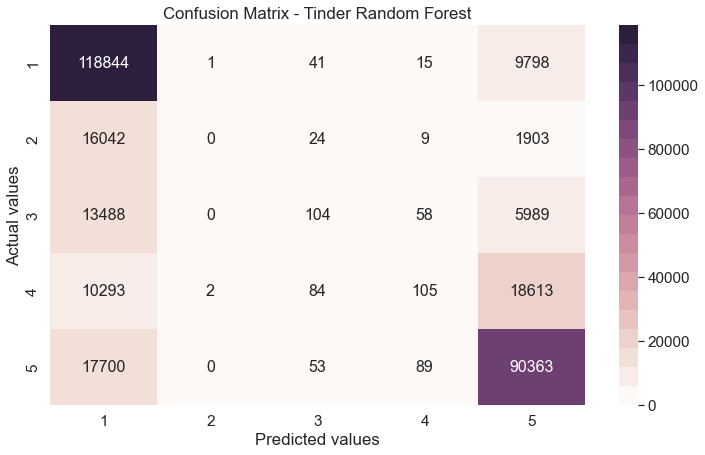

In [14]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_1.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Tinder Random Forest');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

#### Assuming that the optimal params are the same for all sets, we will train the Hinge and Bumble Models using the same params

### Bumble RF Model

In [15]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_B)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

modelB= RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth = 10, class_weight = None)
modelB.fit(x_train, y_train)
modelB.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(modelB,x,y,cv=fold)
cm_2 = confusion_matrix(y_predict,y)

In [16]:
modelB.score(x_test,y_test)

0.6397034414075468

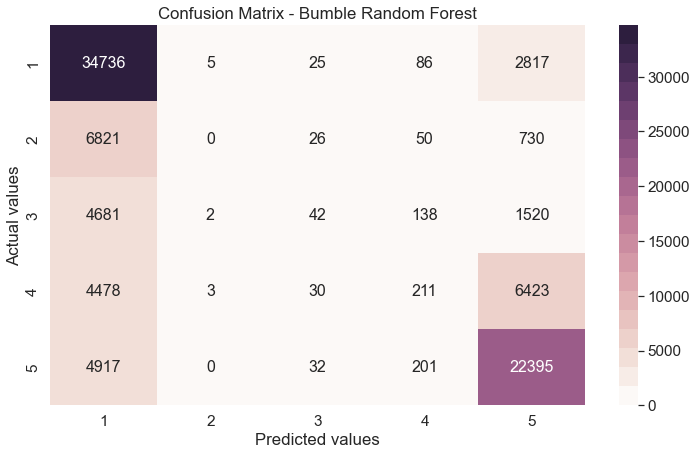

In [17]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_2.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Bumble Random Forest');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

### Hinge RF Model

In [18]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_H)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

modelH= RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth = 10, class_weight = None)
modelH.fit(x_train, y_train)
modelH.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(modelH,x,y,cv=fold)
cm_3 = confusion_matrix(y_predict,y)

In [20]:
modelH.score(x_test,y_test)

0.5625522429646141

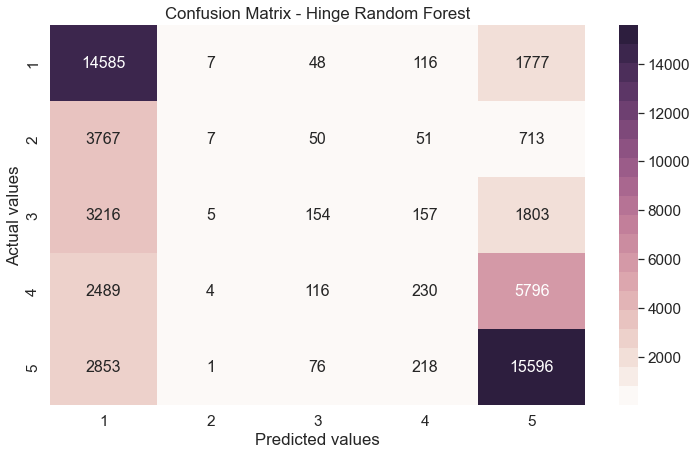

In [21]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_3.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Hinge Random Forest');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

### How well does the RF model trained on Tinder data perform on Hinge and Bumble data? 

We are only performing this analysis on the best performing model.

#### Bumble: performance from Tinder Model

In [6]:
#defs a function that will gather the prediction data from the Hinge or Bumble sets to put through the tinder model
#Returns x-test, the data to feed to the tinder model, and y-actual, the true scores of the Bumble or Hinge set
def get_test(df):
    df_data = df[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
    df_data = df_data.loc[df_data['score'] != 0]

    #all missing data has already been removed. There should be no need to account for it here
    x_test = df_data[['comp_sent', 'pos_sent', 'word_count', 'neg_sent', 'neu_sent']]
    y_actual = df_data['score']
    return x_test,y_actual

### Bumble Results when using the Tinder Model

In [22]:
#gathers x_test and y_actual from Bumble
x_test, y_actual = get_test(df_B)
y_pred = model.predict(x_test)
model.score(x_test, y_actual)

0.6335911651119299

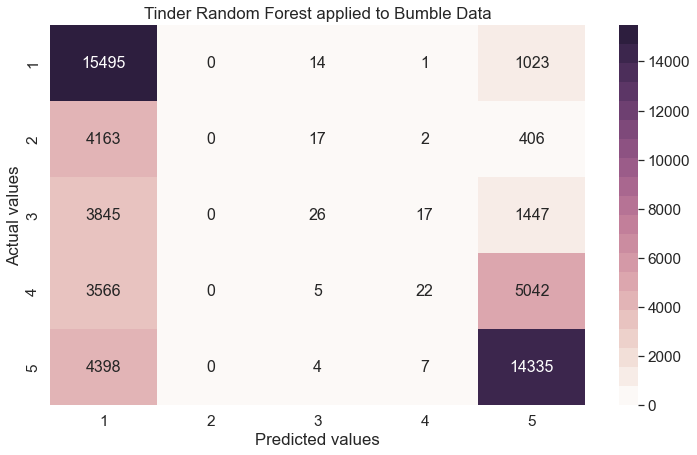

In [28]:
cm_TB = confusion_matrix(y_pred,y_actual)
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_TB.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Tinder Random Forest applied to Bumble Data');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

### Hinge Results with the Tinder Model

In [27]:
#gathers x_test and y_actual from Bumble
x_test, y_actual = get_test(df_H)
y_pred = model.predict(x_test)
model.score(x_test, y_actual)

0.5549921055075694

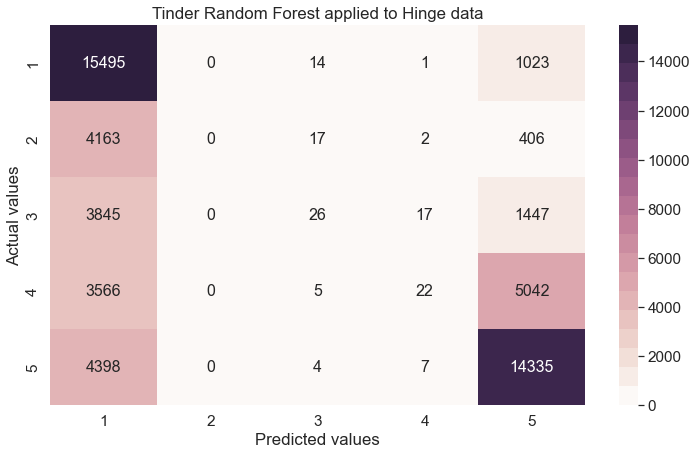

In [25]:
cm_TH = confusion_matrix(y_pred,y_actual)
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_TH.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Tinder Random Forest applied to Hinge data');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

### With this data in mind, we can reasonably assume that models trained on one dating app's data set can be applied to other dating app data sets to get similar results. With that in mind, we are going to train one super model using all three of the datasets here and maximize it's performance. We will do the same for linear regression. 